In [27]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import random
import os

In [28]:
print(torch.cuda.is_available())

True


 **Model Train** only train-loss

In [22]:
# Transformerモデルの定義
class TransformerModel(nn.Module):
    def __init__(self):
        super(TransformerModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=6)
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=512, nhead=8)
        self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=6)

    def forward(self, src, tgt):
        memory = self.encoder(src)
        output = self.decoder(tgt, memory)
        return output

# データの前処理と分割
def preprocess_data(data_file):
    data = np.load(data_file)
    # nanを含む行を削除
    data = data[~np.isnan(data).any(axis=(1,2))]
    X = torch.tensor(data[:, 0, :], dtype=torch.float32)
    y = torch.tensor(data[:, 1, :], dtype=torch.float32)
    y = y.to(X.dtype)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

# ハイパーパラメータの最適化（ランダムサーチ）
def optimize_hyperparameters(model, X_train, y_train, X_val, y_val):
    learning_rate = random.uniform(0.0001, 0.01)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return learning_rate, criterion, optimizer

# 学習関数（チェックポイントの保存先パスを指定）
def train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val, epochs, batch_size, model_path):
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            # targetsのデータタイプをinputsと同じに変換
            #targets = targets.to(inputs.dtype)
            optimizer.zero_grad()
            outputs = model(inputs, targets)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # バッチごとに損失を計算して保存
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss}")
        torch.save(model.state_dict(), os.path.join(model_path, f"checkpoint_epoch_{epoch+1}.pt"))

# 学習データのファイルパス
data_file = "../Datasets/archive/reshaped_text_embeds.npy"
# モデルの保存先ディレクトリ
model_path = "../Models/ClIP_converter/"

# ディレクトリが存在しない場合は作成
os.makedirs(model_path, exist_ok=True)

# モデルの初期化
model = TransformerModel()

# データの前処理と分割
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data(data_file)

# ハイパーパラメータの最適化
learning_rate, criterion, optimizer = optimize_hyperparameters(model, X_train, y_train, X_val, y_val)

# モデルの学習
epochs = 100
batch_size = 64
train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val, epochs, batch_size, model_path)

Epoch 1/100, Loss: 0.7905016644247647
Epoch 2/100, Loss: 0.4769673203599864
Epoch 3/100, Loss: 0.23303348879361974
Epoch 4/100, Loss: 0.08313925050455949
Epoch 5/100, Loss: 0.026643522276446736
Epoch 6/100, Loss: 0.008585720804744753
Epoch 7/100, Loss: 0.003387983976702752
Epoch 8/100, Loss: 0.0018617285130513382
Epoch 9/100, Loss: 0.001520178983277031
Epoch 10/100, Loss: 0.0013893735494689438
Epoch 11/100, Loss: 0.0013532646658734001
Epoch 12/100, Loss: 0.0013291308824936378
Epoch 13/100, Loss: 0.0013110842214544014
Epoch 14/100, Loss: 0.0012840134179990354
Epoch 15/100, Loss: 0.0012678501079790294
Epoch 16/100, Loss: 0.0012862601734954736
Epoch 17/100, Loss: 0.004547456287425654
Epoch 18/100, Loss: 0.0024091863486883714
Epoch 19/100, Loss: 0.0017170013342020583
Epoch 20/100, Loss: 0.0016277255490422249
Epoch 21/100, Loss: 0.0016474628556070142
Epoch 22/100, Loss: 0.0015154895593476449
Epoch 23/100, Loss: 0.0015407965060901538
Epoch 24/100, Loss: 0.0014461243810164261
Epoch 25/100, Lo

In [13]:
data = np.load(data_file)
# nanを含む行を削除
data = data[~np.isnan(data).any(axis=(1,2))]
X = torch.tensor(data[:, 0, :], dtype=torch.float16)
y = torch.tensor(data[:, 1, :], dtype=torch.float16)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(X_train.dtype)
print(y_train.dtype)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

torch.float16
torch.float16
torch.Size([461, 512])
torch.Size([461, 512])
torch.Size([461, 512])
torch.Size([461, 512])


In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Transformerモデルの定義
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, num_layers=6):
        super(TransformerModel, self).__init__()
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(input_dim, nhead=8), num_layers)
        self.decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(input_dim, nhead=8), num_layers)
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        output = self.fc(x)
        return output

# データセットの定義
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]
        
# データセットの前処理
def preprocess_dataset(dataset):
    dataset = dataset[~np.isnan(dataset).any(axis=(1,2))]
    x = dataset[:, 0, :-1]  # 入力データ
    y = dataset[:, 1, :]    # 教師データ
    return x, y

# データセットの分割
def split_dataset(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
    return x_train, x_val, x_test, y_train, y_val, y_test

# 学習曲線の保存
def save_learning_curve(train_losses, val_losses):
    np.save('../Models/ClIP_converter/train_losses.npy', train_losses)
    np.save('../Models/ClIP_converter/val_losses.npy', val_losses)

# トレーニング関数
def train(model, device, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0
    for data in train_loader:
        inputs = data.to(device)
        targets = data.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(train_loader)

# バリデーション関数
def validate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            inputs = data.to(device)
            targets = data.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()

    return val_loss / len(val_loader)

# メイン関数
if __name__ == '__main__':
    # 乱数シードの設定
    torch.manual_seed(42)
    np.random.seed(42)
    
    # デバイスの設定
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # データセットの読み込み
    dataset = np.load('../Datasets/archive/reshaped_text_embeds.npy')
    
    # データセットの前処理
    x, y = preprocess_dataset(dataset)
    
    # データセットの分割
    x_train, x_val, x_test, y_train, y_val, y_test = split_dataset(x, y)
    
    # データローダーの作成
    train_dataset = MyDataset(x_train)
    val_dataset = MyDataset(x_val)
    test_dataset = MyDataset(x_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    test_loader = DataLoader(test_dataset, batch_size=32)
    
    # モデルの定義
    model = TransformerModel(512, 512)
    model.to(device)
    
    # 損失関数と最適化手法の定義
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # モデルの保存先ディレクトリ
    model_path = "../Models/ClIP_converter/"

    # ディレクトリが存在しない場合は作成
    os.makedirs(model_path, exist_ok=True)
    
    # 学習の実施
    num_epochs = 10
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        train_loss = train(model, device, train_loader, criterion, optimizer)
        val_loss = validate(model, device, val_loader, criterion)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        # チェックポイントの保存
        torch.save(model.state_dict(), os.path.join(model_path, f"checkpoint_epoch_{epoch+1}.pt"))
    
    # 学習曲線の保存
    save_learning_curve(train_losses, val_losses)
    
    # テストデータによる評価
    test_loss = validate(model, device, test_loader, criterion)
    print(f"Test Loss: {test_loss:.4f}")

AssertionError: was expecting embedding dimension of 512, but got 511

In [17]:
import torch
import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, num_layers):
        super(TransformerModel, self).__init__()
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(
            d_model=input_size, nhead=8), num_layers=num_layers)
        self.decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(
            d_model=input_size, nhead=8), num_layers=num_layers)
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        output = self.linear(decoded)
        return output

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# データセットロード
dataset = np.load('../Datasets/archive/reshaped_text_embeds.npy')
input_data = torch.Tensor(dataset[:, 0, :])
target_data = torch.Tensor(dataset[:, 1, :])

# nanを含む要素を取り除く
nan_indices = np.unique(np.argwhere(torch.isnan(input_data)).flatten())
input_data = torch.cat([input_data[i].unsqueeze(0) for i in range(len(input_data)) if i not in nan_indices], dim=0)
target_data = torch.cat([target_data[i].unsqueeze(0) for i in range(len(target_data)) if i not in nan_indices], dim=0)

# データセット分割
train_input, val_input, train_target, val_target = train_test_split(
    input_data, target_data, test_size=0.2, random_state=42)

# データローダーの作成
batch_size = 16
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_input, train_target),
    batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(val_input, val_target),
    batch_size=batch_size, shuffle=False)

# ハイパーパラメータの設定
input_size = train_input.size(1,512)
output_size = train_target.size(1,512)
num_layers = 6
num_epochs = 100
learning_rate = 0.001

# モデルの構築
model = TransformerModel(input_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# モデルの保存先ディレクトリ
model_path = "../Models/ClIP_converter/"

# ディレクトリが存在しない場合は作成
os.makedirs(model_path, exist_ok=True)

# 学習
train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    
    model.train()
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    # チェックポイントの保存
    torch.save(model.state_dict(), os.path.join(model_path, f"checkpoint_epoch_{epoch+1}.pt"))

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss}, Val Loss: {val_loss}')

# 損失曲線の保存
np.save('train_loss.npy', train_loss_list)
np.save('val_loss.npy', val_loss_list)

TypeError: size() received an invalid combination of arguments - got (int, int), but expected one of:
 * (int dim)
 * ()
 * (name dim)


**Model Train** train-loss + val-loss + best model saving + learnning curve

Device: cuda
Epoch 1/20, Loss: 0.5964320733629423
Epoch 1/20, Validation Loss: 0.2682914175093174
Epoch 2/20, Loss: 0.12197788859364288
Epoch 2/20, Validation Loss: 0.011819765088148415
Epoch 3/20, Loss: 0.010125590391970914
Epoch 3/20, Validation Loss: 0.0014335463056340814
Epoch 4/20, Loss: 0.005484669830585862
Epoch 4/20, Validation Loss: 0.0013040810299571604
Epoch 5/20, Loss: 0.0030858503084565544
Epoch 5/20, Validation Loss: 0.0013026828091824427
Epoch 6/20, Loss: 0.00213244228206318
Epoch 6/20, Validation Loss: 0.0013259629922686145
Epoch 7/20, Loss: 0.001845698623018789
Epoch 7/20, Validation Loss: 0.001265464918105863
Epoch 8/20, Loss: 0.0016534715100063075
Epoch 8/20, Validation Loss: 0.0012798247917089611
Epoch 9/20, Loss: 0.0015818183591332414
Epoch 9/20, Validation Loss: 0.0012697417550953105
Epoch 10/20, Loss: 0.0015176001189533494
Epoch 10/20, Validation Loss: 0.0012661668588407338
Epoch 11/20, Loss: 0.0014697222946340154
Epoch 11/20, Validation Loss: 0.00124237267300486

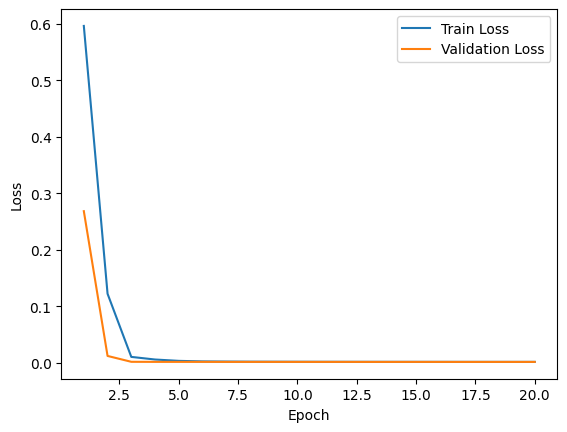

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import random
import os

# Transformerモデルの定義
class TransformerModel(nn.Module):
    def __init__(self):
        super(TransformerModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=6)
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=512, nhead=8)
        self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=6)

    def forward(self, src, tgt):
        memory = self.encoder(src)
        output = self.decoder(tgt, memory)
        return output

# データの前処理と分割
def preprocess_data(data_file):
    data = np.load(data_file)
    # nanを含む行を削除
    data = data[~np.isnan(data).any(axis=(1, 2))]
    X = torch.tensor(data[:, 0, :], dtype=torch.float32)
    y = torch.tensor(data[:, 1, :], dtype=torch.float32)
    y = y.to(X.dtype)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

# ハイパーパラメータの最適化（ランダムサーチ）
def optimize_hyperparameters(model, X_train, y_train, X_val, y_val):
    learning_rate = random.uniform(0.0001, 0.01)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return learning_rate, criterion, optimizer

# 精度の計算
def calculate_accuracy(model, criterion, X_test, y_test):
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs, targets)
            loss = criterion(outputs, targets)
            running_loss += loss.item()

    avg_loss = running_loss / len(test_loader)
    return avg_loss

# 学習関数（チェックポイントと精度の保存先パスを指定）
def train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val, X_test, y_test, epochs, batch_size, model_path):
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

    best_val_loss = float('inf')
    avg_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, targets)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # バッチごとに損失を計算
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss}")

        # テストデータで損失を計算
        val_loss = calculate_accuracy(model, criterion, X_test, y_test)
        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss}")

        avg_losses.append(avg_loss)
        val_losses.append(val_loss)

        # 精度が改善した場合はモデルを保存
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), os.path.join(model_path, "best_model.pt"))

    # 学習曲線を保存
    np.save(os.path.join(model_path, "learning_curve.npy"), np.array([avg_losses, val_losses]))

    # 学習終了後、モデルを保存
    torch.save(model.state_dict(), os.path.join(model_path, "final_model.pt"))

    # 学習曲線を出力
    import matplotlib.pyplot as plt
    plt.plot(range(1, epochs+1), avg_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 学習データのファイルパス
data_file = "../Datasets/archive/reshaped_text_embeds.npy"
# モデルの保存先ディレクトリ
model_path = "../Models/ClIP_converter/"

# ディレクトリが存在しない場合は作成
os.makedirs(model_path, exist_ok=True)

# CUDAが利用可能かチェック
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# モデルの初期化
model = TransformerModel().to(device)
if device == "cuda":
    model = model.cuda()

# データの前処理と分割
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data(data_file)

# ハイパーパラメータの最適化
learning_rate, criterion, optimizer = optimize_hyperparameters(model, X_train, y_train, X_val, y_val)

# モデルの学習
epochs = 20
batch_size = 64
train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val, X_test, y_test, epochs, batch_size, model_path)

**Model Load Test**

In [4]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import os

# Transformerモデルの定義
class TransformerModel(nn.Module):
    def __init__(self):
        super(TransformerModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=6)
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=512, nhead=8)
        self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=6)

    def forward(self, src, tgt):
        memory = self.encoder(src)
        output = self.decoder(tgt, memory)
        return output

# 学習後に保存されたモデルのパス
model_path = "../Models/ClIP_converter/best_model.pt"

# モデルの初期化
model = TransformerModel()
# GPUを利用可能であればGPUにモデルを転送
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

# テスト用のランダムな(1,512)のテンソルを生成
random_input = torch.randn(1, 512).to(device)

# モデルにランダムな入力を与えてテスト
with torch.no_grad():
    model.eval()
    output = model(random_input, random_input)

# 出力を表示
print("Output tensor shape:", output.shape)
print("Sample of output tensor:", output)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Output tensor shape: torch.Size([1, 512])
Sample of output tensor: tensor([[-0.0407,  0.0420, -0.0433,  0.0037, -0.0062, -0.0019,  0.0267,  0.0348,
          0.0090, -0.0205,  0.0404, -0.0121, -0.0046, -0.0036,  0.0285,  0.0110,
         -0.0206,  0.0065,  0.0068, -0.0349, -0.0176,  0.0030,  0.0074,  0.0229,
         -0.0210,  0.0029, -0.0183, -0.0021,  0.0298, -0.0150, -0.0274,  0.0070,
          0.0160, -0.0021,  0.0084,  0.0241, -0.0079, -0.0246,  0.0521,  0.0162,
          0.0813,  0.0542,  0.0023, -0.0403,  0.0340, -0.0165, -0.0344, -0.0055,
          0.0346, -0.0241, -0.0031,  0.0134,  0.0007,  0.0206, -0.0029,  0.0435,
         -0.0192,  0.0019,  0.0210, -0.0099, -0.0242,  0.0012,  0.0096,  0.0271,
         -0.0080, -0.0056,  0.0030,  0.0211, -0.0122,  0.0196, -0.0419, -0.0130,
          0.0002, -0.0432, -0.0140, -0.0406,  0.0286, -0.0083, -0.0769, -0.0689,
          0.0386, -0.0707, -0.0088, -0.0280, -0.0173,  0.0089,  0.0195,  0.0104,
          0.0401,  0.0102, -0.0321, -0.025

**CLIP+Converter vs CLAP**

In [5]:
import torch
import clip
import laion_clap
import numpy as np
import librosa

model1, preprocess1 = clip.load("ViT-B/32", device=device)
model2 = laion_clap.CLAP_Module(enable_fusion=False, amodel= 'HTSAT-base')
model2.load_ckpt('../Models/Laion_CLAP/music_audioset_epoch_15_esc_90.14.patched.pt')

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
tokenizer_config.json: 100%|██████████████████████████████████████████████████████████████████████████████| 28.0/28.0 [00:00<00:00, 77.9kB/s]
vocab.txt: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 232k/232k [00:00<00:00, 553kB/s]
tokenizer.json: 100%|██████████████████████████████████████████████████████████████████████████████████████| 466k/466k [00:00<00:00, 935kB/s]
config.json: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 570/570 [00:00<00:00, 1.89MB/s]
vocab.json: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 899k/899k [00:00<00:00, 1.85MB/s]
merges.txt: 100%|████████████████████████████

Load the specified checkpoint ../Models/Laion_CLAP/music_audioset_epoch_15_esc_90.14.patched.pt from users.
Load Checkpoint...
logit_scale_a 	 Loaded
logit_scale_t 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_real.weight 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_imag.weight 	 Loaded
audio_branch.logmel_extractor.melW 	 Loaded
audio_branch.bn0.weight 	 Loaded
audio_branch.bn0.bias 	 Loaded
audio_branch.patch_embed.proj.weight 	 Loaded
audio_branch.patch_embed.proj.bias 	 Loaded
audio_branch.patch_embed.norm.weight 	 Loaded
audio_branch.patch_embed.norm.bias 	 Loaded
audio_branch.layers.0.blocks.0.norm1.weight 	 Loaded
audio_branch.layers.0.blocks.0.norm1.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.relative_position_bias_table 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.bias 	 Loaded
audio_b

In [19]:
text_data = "a cat"
with torch.no_grad():
    # model2.get_text_embeddingの前にtext_dataを配列に変換
    token = clip.tokenize(text_data).to(device)
    text_embed_clip = model1.encode_text(token)
    print(text_embed_clip.shape)
    print(text_embed_clip.dtype)
    text_embed_clip = text_embed_clip.to(torch.float32)
    print(text_embed_clip.dtype)

    # text_dataを2要素の配列に変換
    text_data_array = [text_data, ""]
    text_embed_clap = model2.get_text_embedding(text_data_array, use_tensor=True).to(device)
    # [2, 512]のTensorから第一要素を取り出し、[1, 512]のTensorにする
    text_embed_clap = text_embed_clap[0].unsqueeze(0)
    print(text_embed_clap.shape)
    print(text_embed_clap.dtype)

torch.Size([1, 512])
torch.float16
torch.float32
torch.Size([1, 512])
torch.float32


In [22]:
# モデルにランダムな入力を与えてテスト
with torch.no_grad():
    model.eval()
    output = model(text_embed_clip, text_embed_clip)

# 出力を表示
print("Output tensor shape:", output.shape)
print("Output tensor dtype:", output.dtype)
#print("Sample of output tensor:", output)
criterion = nn.MSELoss()
loss = criterion(output, text_embed_clap)
print(loss)

Output tensor shape: torch.Size([1, 512])
Output tensor dtype: torch.float32
tensor(0.0020, device='cuda:0')


In [26]:
import sys
print(sys.version)

3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
